<h3> 🌌 Dataset Description</h3>

<p>You will have access to a training set and a test set. The training set contains the position and velocity measurements of the three bodies for different time steps. You sholid use this data to train your model and learn to propagate the trajectories of the objects. The test set contains an initial position and several time steps. Using your trained model, you sholid predict the positions of the three objects starting from the initial position. Additionally, you have access to a sample submission. This is an example of what your submission files sholid look like so that the system can accept them welwelelelelee.</p>

<h5>📁 Files</h5>
<ul>
  <li><code>X_train.csv</code> — training set (1,285,000 rows, 14 cols; 5000 trajectories × 257 timesteps)</li>
  <li><code>X_test.csv</code> — test set (1,041,621 rows, 8 cols; 4053 trajectories × 257 timesteps)</li>
  <li><code>sample_submission.csv</code> — example in the correct format (random predictions)</li>
</ul>

<h4>X_train Columns</h4>
<ul>
  <li><code>Id</code> — row index (use <code>traj_id = Id // 257</code>)</li>
  <li><code>t</code> — timestep</li>
  <li><code>x_1, y_1, v_x_1, v_y_1</code> — position/velocity of object 1</li>
  <li><code>x_2, y_2, v_x_2, v_y_2</code> — position/velocity of object 2</li>
  <li><code>x_3, y_3, v_x_3, v_y_3</code> — position/velocity of object 3</li>
</ul>

<h4>X_test Columns</h4>
<ul>
  <li><code>Id</code> — row id (257 rows per trajectory)</li>
  <li><code>t</code> — timestep</li>
  <li><code>x0_1, y0_1</code> — object 1 initial position (t=0)</li>
  <li><code>x0_2, y0_2</code> — object 2 initial position (t=0)</li>
  <li><code>x0_3, y0_3</code> — object 3 initial position (t=0)</li>
</ul>

<p><b>Note:</b> After a collision, remaining rows in that trajectory are zero-padded (features become zero; <code>t</code> may be 0). Exclude these rows when training/validating.</p>



<h3>📚 Imports</h3>

In [5]:
import matplotlib.pyplot as plt                        # Library for plotting graphs and visualizations
import numpy as np                                     # Library for numerical computing (arrays, math functions)
import pandas as pd                                    # Library for handling datasets (tables, CSVs, DataFrames)
from sklearn.metrics import mean_squared_error , root_mean_squared_error  # Function to evaluate model performance using MSE
from sklearn.model_selection import train_test_split   # Utility to split dataset into training and testing sets
from sklearn.preprocessing import StandardScaler       # Tool to normalize/standardize features
from sklearn.preprocessing import PolynomialFeatures   # Generates polynomial features for non-linear regression
from sklearn.pipeline import make_pipeline             # Builds pipelines that chain preprocessing + model steps
from sklearn.linear_model import LinearRegression      # Ordinary least squares linear regression model
from sklearn.linear_model import Ridge, RidgeCV        # Ridge regression (L2 regularization) and Ridge with cross-validation
from sklearn.compose import ColumnTransformer          # Apply transformations to specific columns of the dataset
from sklearn.preprocessing import FunctionTransformer  # Apply custom functions to transform data
from sklearn.neighbors import KNeighborsRegressor      # k-Nearest Neighbors regression model
from sklearn.multioutput import MultiOutputRegressor   # Extend regressors to multi-output problems
import math                                            # Python built-in math library
import time                                            # Python built-in library to measure execution time
import seaborn as sns                                  #Statistical data visualization                           
import os                                              #Python built-in library for operating system dependent functionality

<h3>📂 Load Data</h3>

In [6]:
data = pd.read_csv("../../data/X_train.csv")
test = pd.read_csv("../../data/X_test.csv")

data.head()  # Display the first few rows of the dataset to understand its structure
data.columns  # List all column names to identify features and target variable

Index(['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id'],
      dtype='object')

<h2>Task 1 - Setting the Baseline</h2>
<h3>Task 1.1 - Data Preparation and Validation Pipeline</h3>

<h3>Exploration + grafic Functions (insightful)</h3>

,Metric,Value
0,Rows,1285000
1,Cols,22
2,Number of trajectories with colisions,5000
3,Steps per trajectory (min),257
4,Steps per trajectory (max),257
5,Steps per trajectory (mean),257.00
6,% Colision rows rows,15.19%
7,"Range of time [min,max]","[0.0, 10.0]"


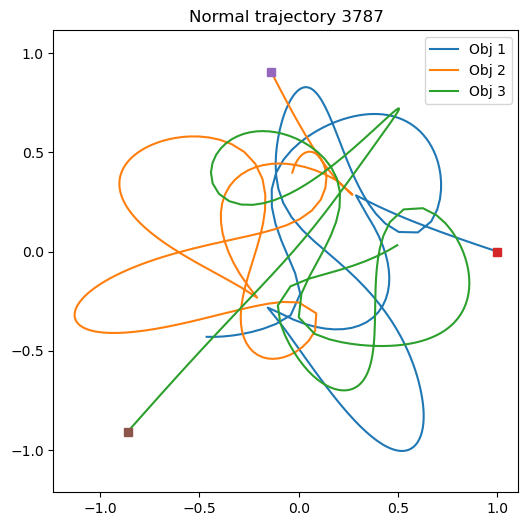

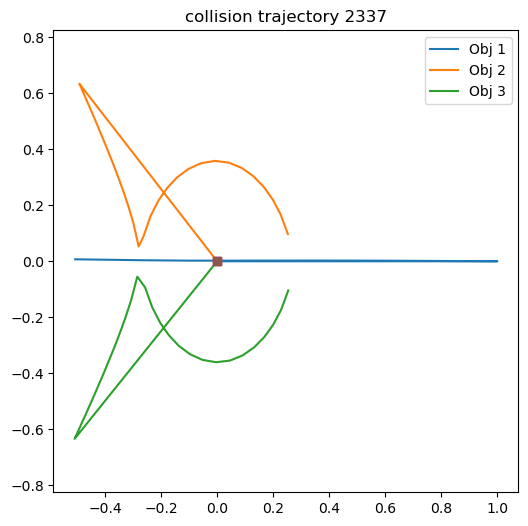

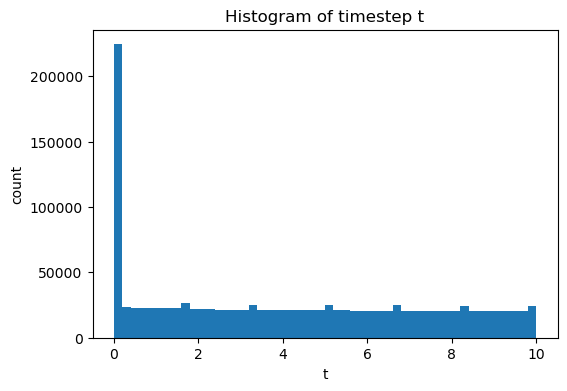

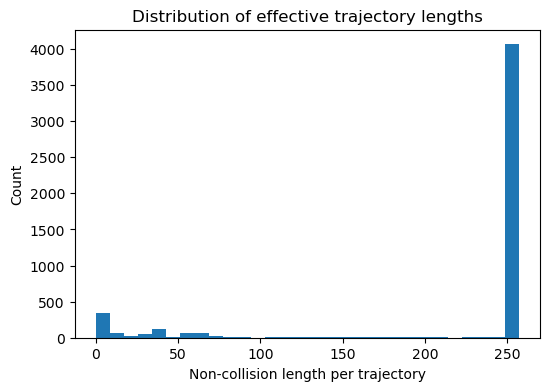

Total of lines with collision and colisions: 243379
Total of trajectories with collision and colisions: 947
Total of lines without collision and colisions: 1041621
Total of trajectories without collision and colisions: 4053
Train: (729109, 7) (729109, 6)
Val:   (155999, 7) (155999, 6)
Test:  (156513, 7) (156513, 6)


In [7]:
##### Data visualization #####

#Creates a unique identifier for each trajectory
#Essential to group lines by trajectory (to exclude collisions and make correct division)
def add_traj_id(df, steps_per_traj= 257):
    df=df.copy() # Avoid modifying the original DataFrame
    df["traj_id"] = (df["Id"] // steps_per_traj) #Each trajectory has 257 steps, e.g index 0-256 -> traj_id 0, index 257-514 -> traj_id 1, etc.
    return df

#Identifies all the lines that have a colision with True
#Essential for filtering colisions and the trajectories with colisions 
def mark_collision(df):
    df=df.copy()
    feat_cols = [
        'x_1','y_1','v_x_1','v_y_1',
        'x_2','y_2','v_x_2','v_y_2',
        'x_3','y_3','v_x_3','v_y_3'
    ]
    df["is_collision"] = (df[feat_cols].abs().sum(axis=1)==0) #If all feature columns are zero, mark as colision (True)
    return df

#Identifies the initial position of each trajectorie and puts with x0_* and y0_*
#Essential to use the starting positions as static features.
def add_initial_positions(df):
    df=df.copy()
    first =df.loc[df.groupby("traj_id")["t"].idxmin(),  # Get the first row (t=0) for each trajectory
        ["traj_id","x_1","y_1","x_2","y_2","x_3","y_3"]].rename(columns={
        "x_1":"x0_1","y_1":"y0_1",
        "x_2":"x0_2","y_2":"y0_2",
        "x_3":"x0_3","y_3":"y0_3"
    })
    #Get the positions x,y for t=0 and rename the columns to x0_*, y0_* for each object
    df= df.merge(first, on="traj_id", how="left")
    return df

#Pipeline
def preprocess_train(df, steps_per_traj=257):
    df = add_traj_id(df, steps_per_traj=steps_per_traj)
    df = mark_collision(df)
    df = add_initial_positions(df)
    return df #Final dataset with traj_id, is collision, x0_*, y0_*, x_*, y_*, v_x_*, v_y_*

#Dataset visualization
#Important for exploring and documenting the database
def dataset_overview(df):
    n_rows, n_cols = df.shape #Number of lines and columns
    n_traj = df["traj_id"].nunique() #Number of unique trajectories
    steps_per_traj = df.groupby("traj_id")["t"].size() #Number of steps per trajectory
    colision_rows = 100 * df["is_collision"].mean()  #Percentage of collision rows

    info = pd.DataFrame({
        "Metric": [
            "Rows", 
            "Cols",
            "Number of trajectories with colisions",
            "Steps per trajectory (min)",
            "Steps per trajectory (max)",
            "Steps per trajectory (mean)",
            "% Colision rows rows",
            "Range of time [min,max]"
        ],
        "Value": [
            n_rows, 
            n_cols,
            n_traj,
            steps_per_traj.min(),
            steps_per_traj.max(),
            f"{steps_per_traj.mean():.2f}",
            f"{colision_rows:.2f}%",
            f"[{df['t'].min()}, {df['t'].max()}]"
        ]
    })
    return info

#Finds the trajectories that were classified has True in collision
#Important for insight into dynamics and collisions.
def find_collision_traj(df):
    has_pad = df.groupby("traj_id")["is_collision"].any() #Check which trajectories have any collision (True)
    colision_id = has_pad[has_pad].index #Get the traj_id of those trajectories
    return int(np.random.choice(colision_id)) if len(colision_id) > 0 else None #Choses one collision trajectory randomly 

#Histogram of non_collisions trajectories
#Important for understanding the effective trajectory lengths 
def plot_hist_noncollision_lengths(df): 
    g = df.groupby("traj_id") #Join all the lines for the same trajectory
    lengths = (g["is_collision"].apply(lambda s: (~s).sum())).values #Count the number of non-collision lines per trajectory
    plt.figure(figsize=(6,4))
    plt.hist(lengths, bins=30)
    plt.xlabel("Non-collision length per trajectory")
    plt.ylabel("Count")
    plt.title("Distribution of effective trajectory lengths")
    plt.show()
 
#Histogram os a random trajectory
#Important for visualizing the movement patterns of objects in a trajectory
def plot_one_trajectory(df, traj_id=None, title_prefix="Trajectory"):
    if traj_id is None:
        traj_id = np.random.choice(df["traj_id"].unique()) #Choose a random trajectory if none is provided

    d = df.loc[df["traj_id"] == traj_id].sort_values("t") #Get all lines for the selected trajectory and sort by time
    plt.figure(figsize=(6,6))
    plt.plot(d["x_1"], d["y_1"], label="Obj 1")
    plt.plot(d["x_2"], d["y_2"], label="Obj 2")
    plt.plot(d["x_3"], d["y_3"], label="Obj 3")
    plt.plot(d["x_1"].iloc[0], d["y_1"].iloc[0], 's')
    plt.plot(d["x_2"].iloc[0], d["y_2"].iloc[0], 's')
    plt.plot(d["x_3"].iloc[0], d["y_3"].iloc[0], 's')
    plt.axis('equal')
    plt.legend()
    plt.title(f"{title_prefix} {traj_id}")
    plt.show()

#Plots 
def plot_t_hist(df):
    plt.figure(figsize=(6,4))
    plt.hist(df["t"], bins=50)
    plt.xlabel("t")
    plt.ylabel("count")
    plt.title("Histogram of timestep t")
    plt.show()

#Show the results
train = preprocess_train(data, steps_per_traj=257)
overview = dataset_overview(train)
display(overview)
plot_one_trajectory(train, traj_id=None, title_prefix="Normal trajectory") #Plot a random trajectory
col_traj = find_collision_traj(train)
if col_traj is not None:
    plot_one_trajectory(train, traj_id=col_traj, title_prefix="collision trajectory") #Plot a random collision trajectory
else:
    print("No collision trajectories found (no collision)")

plot_t_hist(train)
plot_hist_noncollision_lengths(train)

##### Data splitting #####

#Definition of features and targets
FEATURES = ["t","x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]
TARGETS  = ["x_1","y_1","x_2","y_2","x_3","y_3"]

#Defining split function in 70% train, 15% test and 15%validation
def make_train_val_test_split( 
    dataset: pd.DataFrame,
    features: list = FEATURES,
    targets: list  = TARGETS,
    train_size: float = 0.7,
    val_size: float = 0.15,
    test_size: float = 0.15,
    random_state: int = 42 #For reproducibility of the random split
):
    #Making sure that the sum of the fractions is 1
    assert abs(train_size + val_size + test_size - 1.0) < 1e-8, "Sum of fractions is 1"
    
    #Removing all the lines with collision
    traj_with_collision = dataset.loc[dataset["is_collision"], "traj_id"].unique()
    
    #Removing colisions
    collision_mask = (dataset["t"] == 0) & \
                     (dataset[["x_1","y_1","x_2","y_2","x_3","y_3"]] == 0).all(axis=1)
    
    traj_with_collision = dataset.loc[collision_mask, "traj_id"].unique()
    
    lines_with_pad_or_collision = dataset["traj_id"].isin(traj_with_collision) | dataset["traj_id"].isin(traj_with_collision)

    print("Total of lines with collision and colisions:", lines_with_pad_or_collision.sum())
    print("Total of trajectories with collision and colisions:", dataset.loc[lines_with_pad_or_collision, 'traj_id'].nunique())
    
    dataset= dataset[~dataset["traj_id"].isin(traj_with_collision) & 
                        ~dataset["traj_id"].isin(traj_with_collision)]
    
    print("Total of lines without collision and colisions:", dataset.shape[0])
    print("Total of trajectories without collision and colisions:", dataset['traj_id'].nunique())

    #Making sure that the trajectories are unique 
    unique_traj = np.array(dataset["traj_id"].unique()) #Get unique trajectory IDs
    np.random.seed(random_state) #Set random seed for reproducibility
    np.random.shuffle(unique_traj) #Shuffle the trajectory IDs randomly

    #Total number of unique trajectories and dividing fot each split according to the fractions and the total number of unique trajectories
    n_total = len(unique_traj) 
    n_train = int(train_size * n_total)
    n_val   = int(val_size * n_total)
    n_test = n_total - n_train - n_val

    #Getting the trajectory IDs for each split in an indenpendent manner
    tr_ids = unique_traj[:n_train]
    va_ids = unique_traj[n_train:n_train+n_val]
    te_ids = unique_traj[n_train+n_val:]
    
    #Creating a dataset with the trajectory IDs per split
    tr = dataset[dataset["traj_id"].isin(tr_ids)].copy() 
    va = dataset[dataset["traj_id"].isin(va_ids)].copy()
    te = dataset[dataset["traj_id"].isin(te_ids)].copy()
    
    #Ext racting X and Y arrays for each ID of each split 
    X_tr, y_tr = tr[features].values, tr[targets].values
    X_va, y_va = va[features].values, va[targets].values
    X_te, y_te = te[features].values, te[targets].values

    return X_tr, y_tr, X_va, y_va, X_te, y_te, tr, va, te

#Executing split
X_tr, y_tr, X_va, y_va, X_te, y_te, tr_df, va_df, te_df = make_train_val_test_split(train)

print("Train:", X_tr.shape, y_tr.shape)
print("Val:  ", X_va.shape, y_va.shape)
print("Test: ", X_te.shape, y_te.shape)

<h3>Task 1.2 - Learn the baseline model</h3>

Baseline RMSE (validation split): 1.4159063657148816


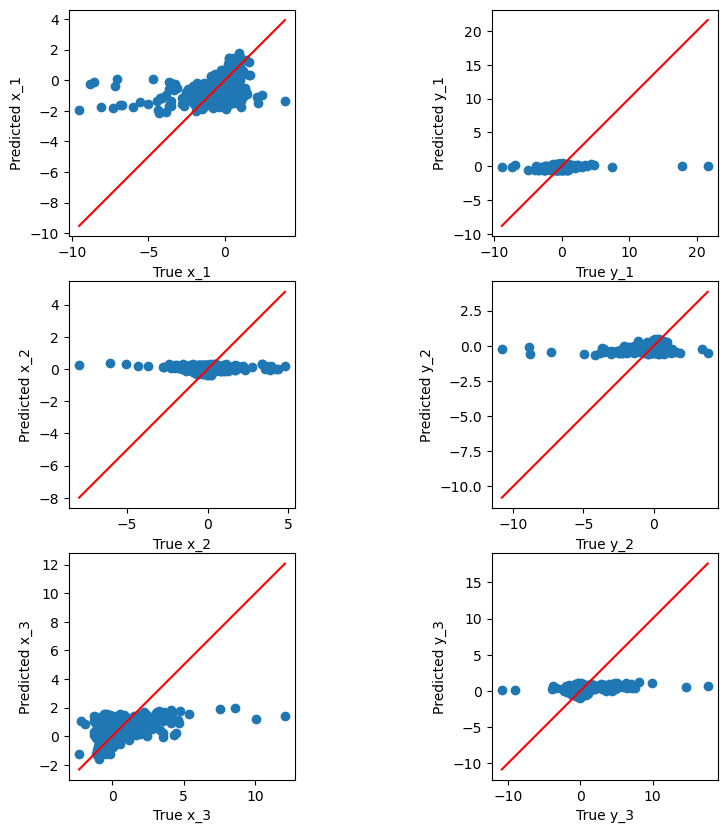

Saved submission file: baseline-model.csv


In [8]:
#Pipeline: StandardScaler for normalizing the values and doing the linear regression
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline.fit(X_tr, y_tr)  #Training the model with X,Y training
y_hat = baseline.predict(X_va)  #y_hat is the prevision for the validation set

#Doing the mean squared error between the prevision (y_hat) and the real values(y_va)
rmse = mean_squared_error(y_va, y_hat) 
rmse_baseline = np.sqrt(mean_squared_error(y_va, y_hat))
print("Baseline RMSE (validation split):", rmse_baseline)

#Plot y_^y
def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    save_dir = "../outputs/pdf"
    os.makedirs(save_dir, exist_ok=True)
    MAX = 500 #Maximum number of points to plot for clarity
    if len(y_test) > MAX: 
        idx = np.random.choice(len(y_test),MAX, replace=False) #Randomly choose MAX indices to plot
    else:
        idx = np.arange(len(y_test)) #Use all indices if less than MAX
    plt.figure(figsize=(10,10))
    for i in range(6): #For each of the 6 target variables
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    save_path = os.path.join(save_dir, plot_title + '.pdf')
    plt.savefig(save_path)
    plt.show()
    

plot_y_yhat(y_va, y_hat, plot_title="baseline_validation")

#Preparing the dataset for training
full = train[~train["is_collision"]].copy()
X_full = full[FEATURES].values
y_full = full[TARGETS].values

#Baseline model
baseline_full = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline_full.fit(X_full, y_full)

#Preparing test
X_test = test[["t","x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]].values
pred = baseline_full.predict(X_test)

#Construct the submission
submission = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": pred[:,0], "y_1": pred[:,1],
    "x_2": pred[:,2], "y_2": pred[:,3],
    "x_3": pred[:,4], "y_3": pred[:,5],
})
submission.to_csv("../outputs/csv/baseline-model.csv", index=False)
print("Saved submission file: baseline-model.csv") 

<h3>Task 2 -  Nonlinear models on the data — the Polynomial model</h3>

<h3>Task 2.1 - Development</h3>

 Linear Regression
degree= 1 | feats=    7 | time=  0.01s | RMSE= 1.4162
degree= 2 | feats=   35 | time=  0.02s | RMSE= 1.3778
degree= 3 | feats=  119 | time=  0.05s | RMSE= 1.3336
degree= 4 | feats=  329 | time=  0.13s | RMSE= 1.2997
degree= 5 | feats=  791 | time=  0.41s | RMSE= 1.2929
[skip] grau 6 → 1715 features (limite 1500)
[skip] grau 7 → 3431 features (limite 1500)
 Best RMSE (Linear): 1.2929166109111911 

 RidgeCV (L2 regularization)
degree= 1 | feats=    7 | time=  0.02s | RMSE= 1.4162
degree= 2 | feats=   35 | time=  0.06s | RMSE= 1.3779
degree= 3 | feats=  119 | time=  0.14s | RMSE= 1.3336
degree= 4 | feats=  329 | time=  0.45s | RMSE= 1.2975
degree= 5 | feats=  791 | time=  1.25s | RMSE= 1.2638
[skip] grau 6 → 1715 features (limite 1500)
[skip] grau 7 → 3431 features (limite 1500)
 Best RMSE (RidgeCV): 1.2637504701353894
Linear summary:
    degree  n_features  fit_time_s  rmse_val
0       1           7    0.013049  1.416203
1       2          35    0.021908  1.377825
2   

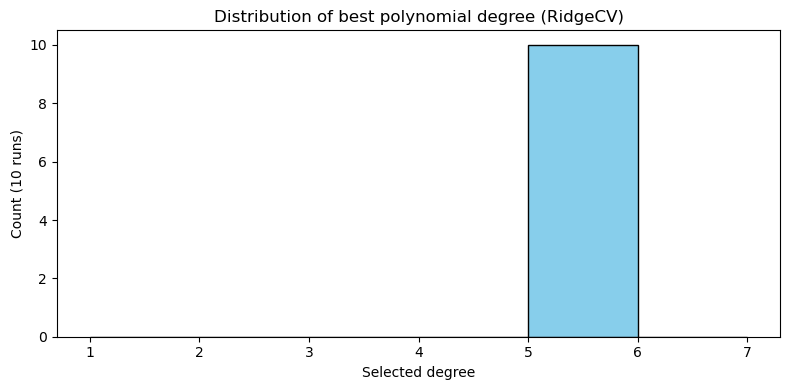

Final chosen degree: 5


In [9]:
#Define the regressor by Ridge regularization to use in the pipeline
def pick_regressor(use_ridge=False, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0)): #Defining the value of lambda for Ridge regularization(penalty term)
    if use_ridge:
        alphas_array = np.array(ridge_alphas)  #If ridge is used, convert the alphas to a numpy array
        regressor = RidgeCV(alphas=alphas_array) #The model is a linear regression with Ridge
    else:
        regressor = LinearRegression() #If ridge is not used, the model is a simple linear regression
    return regressor

#Creates a validation function for polynomial regression models to choose the best degree and model
def validate_polynomial(
    X_train, y_train, X_val, y_val, #Split data from the make_train_val_test_split function
    degrees=range(1, 8),        
    max_features=1500,          
    sample_frac=0.03,         
    random_state=42,
    use_ridge=False,
    ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0),
    verbose=True #Print progress
):
    
    rng = np.random.RandomState(random_state) 
    
    #Creating small training subset for faster validation
    n = len(X_train)
    k = max(1, int(round(sample_frac * n))) #Small number of samples to use from the training set
    idx = rng.choice(n, k, replace=False) #Randomly choose k indices from the small number of samples from training set
    #Train sets only contain the index from k samples
    X_sub = X_train[idx].astype(np.float32, copy=False) 
    y_sub = y_train[idx].astype(np.float32, copy=False)
    
    Xv = X_val.astype(np.float32, copy=False)
    yv = y_val.astype(np.float32, copy=False)

    best_rmse = np.inf #Initialize best RMSE to infinity (any model will be better)
    best_model = None #Keeps the variable for the best model found
    logs = [] #To store logs of each degree tested
    n_in = X_sub.shape[1]

    #Model training
    for d in degrees:
        probe = PolynomialFeatures(degree=d, include_bias=False) #See how many features the polynomial of degree d will generate (without training)
        probe.fit(np.zeros((1, n_in), dtype=np.float32)) 
        n_feats = int(probe.n_output_features_) 

        if max_features is not None and n_feats > max_features: 
            if verbose:
                print(f"[skip] grau {d} → {n_feats} features (limite {max_features})") #Skip this degree if it generates more features than the max_features defined 
            logs.append((d, n_feats, np.nan, np.nan)) 
            continue

        model = pick_regressor(use_ridge=use_ridge, ridge_alphas=ridge_alphas) #Choose the model (Ridge or Linear Regression)
        pipe = make_pipeline(
            PolynomialFeatures(degree=d, include_bias=False), #Expands the features to polynomial features of degree d
            StandardScaler(with_mean=True), #Standardizes the features by the mean
            model
        )

        t0 = time.time() #Measure the time taken to fit the model
        pipe.fit(X_sub, y_sub) #Fit the model with the small training set
        fit_time = time.time() - t0 #Time taken to fit the model

        #Model validation
        pred = pipe.predict(Xv) #Predict the validation set
        rmse = float(np.sqrt(mean_squared_error(yv, pred))) #Calculate the RMSE for the validation set

        logs.append((d, n_feats, fit_time, rmse))
        if verbose:
            print(f"degree={d:>2} | feats={n_feats:>5} | time={fit_time:6.2f}s | RMSE={rmse:7.4f}")

        if rmse < best_rmse: #If the RMSE of this model is better than the best found so far, update best_rmse and best_model
            best_rmse = rmse
            best_model = pipe

    return best_model, best_rmse, logs

#Run a simple validation trial in linear regression and ridge regression
DEGREES=range(1, 8)
MAX_FEATURES=1500
SAMPLE_FRAC=0.03

print(" Linear Regression")
best_lin, rmse_lin, logs_lin = validate_polynomial(
    X_tr, y_tr, X_va, y_va,
    degrees=DEGREES,
    max_features=MAX_FEATURES,
    sample_frac=SAMPLE_FRAC,
    random_state=42,
    use_ridge=False,
    verbose=True
)
print(" Best RMSE (Linear):", rmse_lin, "\n")

print(" RidgeCV (L2 regularization)")
best_ridge, rmse_ridge, logs_ridge = validate_polynomial(
    X_tr, y_tr, X_va, y_va,
    degrees=DEGREES,
    max_features=MAX_FEATURES,
    sample_frac=SAMPLE_FRAC,
    random_state=42,
    use_ridge=True,
    ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0),
    verbose=True
)
print(" Best RMSE (RidgeCV):", rmse_ridge)

#Function to convert logs to a DataFrame for better visualization
def logs_to_df(logs):
    return pd.DataFrame(logs, columns=["degree","n_features","fit_time_s","rmse_val"])

df_lin   = logs_to_df(logs_lin)
df_ridge = logs_to_df(logs_ridge)

print("Linear summary:\n", df_lin)
print("\nRidgeCV summary:\n", df_ridge)

#Choosing the best degree by running 10 times with different training subsets
best_degrees = []
for seed in range(1, 11): #Run 10 times with different random seeds to see the stability of the chosen degree
    mdl, rmse, logs = validate_polynomial(
        X_tr, y_tr, X_va, y_va,
        degrees=DEGREES,
        max_features=MAX_FEATURES,
        sample_frac=0.05,     
        random_state=seed,
        use_ridge=True,
        ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0),
        verbose=False
    )
    df = logs_to_df(logs).dropna(subset=["rmse_val"])
    best_deg = int(df.loc[df["rmse_val"].idxmin(), "degree"])
    best_degrees.append(best_deg)

print("Best degrees across 10 runs:", best_degrees)

plt.figure(figsize=(8, 4))
plt.hist(best_degrees, bins=np.arange(1, 8, 1), edgecolor="black", color="skyblue")
plt.xlabel("Selected degree")
plt.ylabel("Count (10 runs)")
plt.title("Distribution of best polynomial degree (RidgeCV)")
plt.tight_layout()
plt.show()

#Chosing the final degree by majority vote
from collections import Counter
final_degree = Counter(best_degrees).most_common(1)[0][0]
print("Final chosen degree:", final_degree)

<h3>Task 2.2 - compare with baseline and submit</h3>

Chosen model: Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])))])
Polynomial RMSE (validation): 1.26375059574697


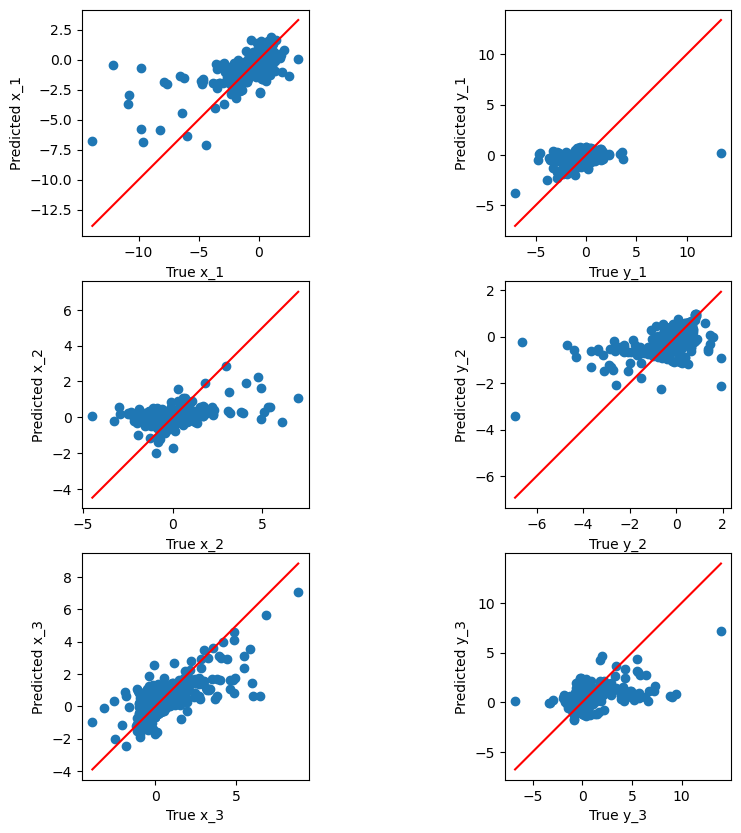

In [10]:
# entre Linear e Ridge, fica o melhor
save_dir = "../outputs/pdf"
os.makedirs(save_dir, exist_ok=True)
chosen_model = best_ridge if rmse_ridge <= rmse_lin else best_lin
print("Chosen model:", chosen_model)

y_va_pred = chosen_model.predict(X_va)
rmse_poly = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
print("Polynomial RMSE (validation):", rmse_poly)

# gráfico y–ŷ (mesma função que já usaste na Task 1)
_ = plot_y_yhat(y_va, y_va_pred, plot_title="poly_validation")

In [11]:
#Preparing the final dataset to train the final model
full = train[~train["is_collision"]].copy()
X_full = full[FEATURES].values
y_full = full[TARGETS].values

#Train on the maximum possible data with the chosen model and the best degree
is_ridge = isinstance(chosen_model.named_steps[list(chosen_model.named_steps.keys())[-1]], RidgeCV)
reg_final = pick_regressor(use_ridge=is_ridge, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0))

#Rebuild pipeline with the final DEGREE and the chosen regressor type
final_model = make_pipeline(
    PolynomialFeatures(degree=int(final_degree), include_bias=False),
    StandardScaler(with_mean=True),
    reg_final
)
final_model.fit(X_full, y_full)

#Test prediction
X_test_arr = test[["t","x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]].values
pred = final_model.predict(X_test_arr)

#Saving submission in required format
polysub = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": pred[:,0], "y_1": pred[:,1],
    "x_2": pred[:,2], "y_2": pred[:,3],
    "x_3": pred[:,4], "y_3": pred[:,5],
})
polysub.to_csv("../assigment#1/outputs/polynomial_submission.csv", index=False)
print(f"Saved: polynomial_submission.csv (degree={final_degree}, ridge={is_ridge})")

Saved: polynomial_submission.csv (degree=5, ridge=True)


<h2> Task 3 -  Feature Engineering </h2>

<h3>Task 3.1 - Removing variables</h3>

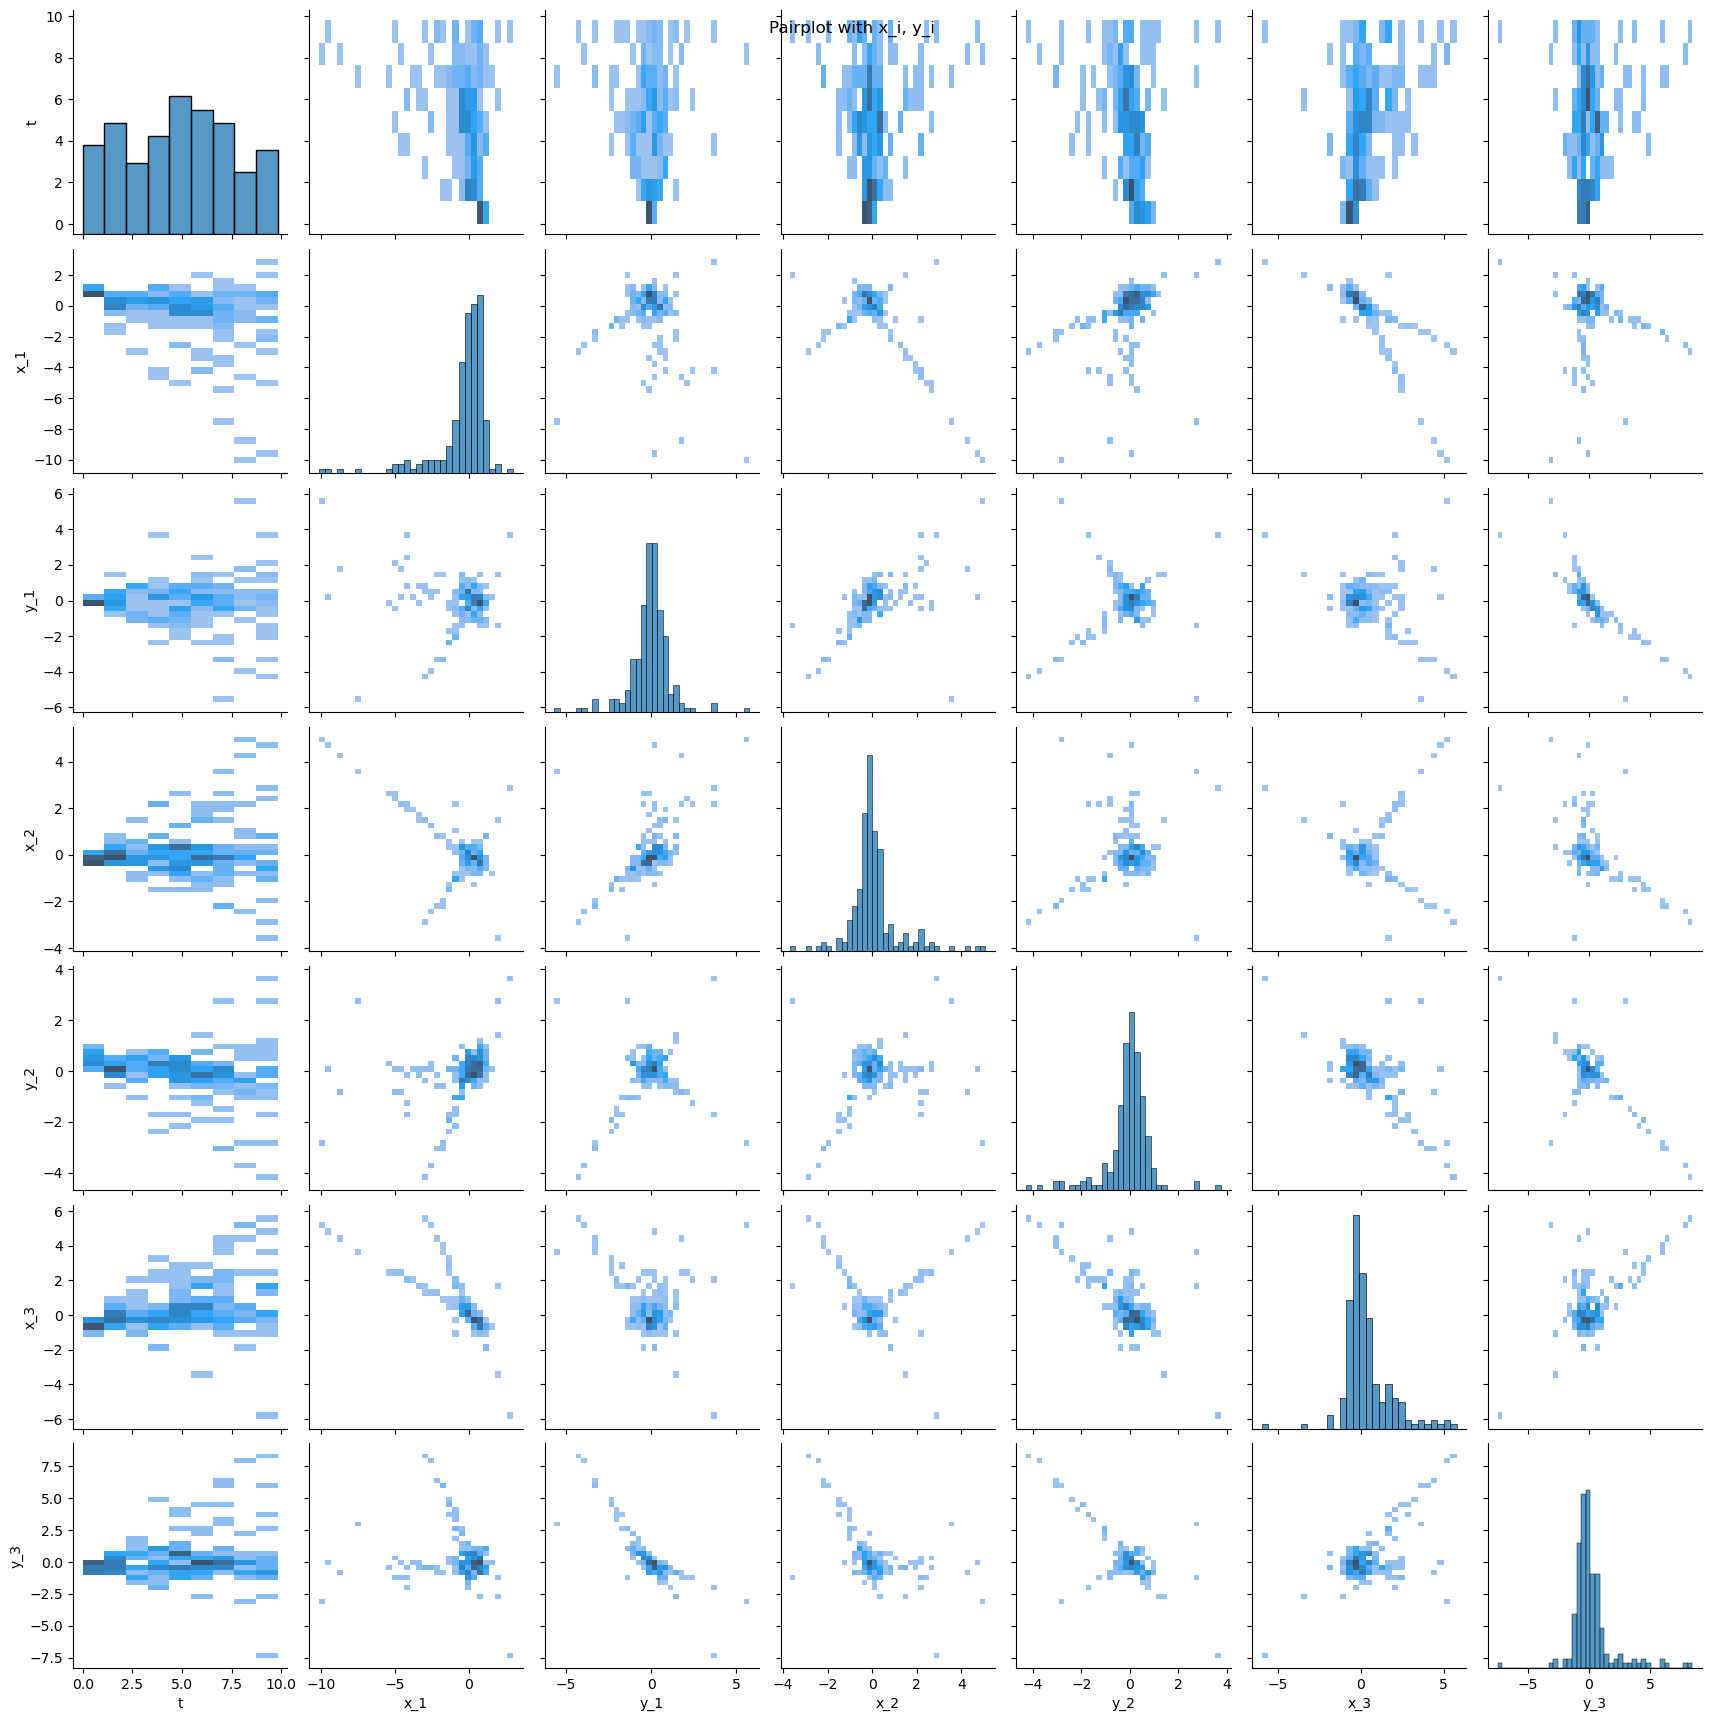

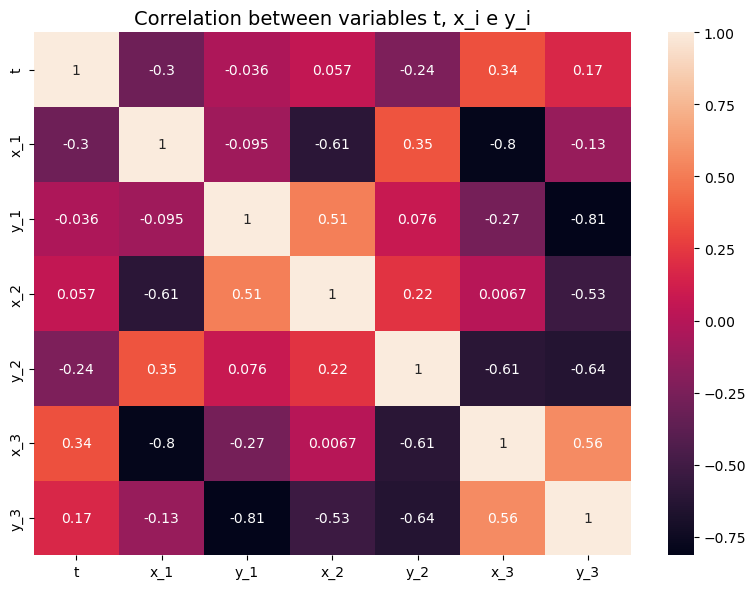

Correlations by order:

t    t      1.000000
y_1  y_3   -0.814632
x_1  x_3   -0.798063
y_2  y_3   -0.640459
     x_3   -0.610174
x_1  x_2   -0.607937
x_3  y_3    0.563446
x_2  y_3   -0.525322
y_1  x_2    0.514985
x_1  y_2    0.351193
t    x_3    0.339845
     x_1   -0.304254
y_1  x_3   -0.270725
t    y_2   -0.237880
x_2  y_2    0.221190
t    y_3    0.166106
x_1  y_3   -0.130825
     y_1   -0.095367
y_1  y_2    0.076320
t    x_2    0.057114
     y_1   -0.036011
x_2  x_3    0.006737
dtype: float64
 Baseline RMSE (WITHOUT REMOVAL): 1.261110479473858
Removed t → 6 features left
Removed x0_1 → 6 features left
Removed y0_1 → 6 features left
Removed x0_2 → 6 features left
Removed y0_2 → 6 features left
Removed x0_3 → 6 features left
Removed y0_3 → 6 features left
Removed      t  RMSE = 1.4587842632518775


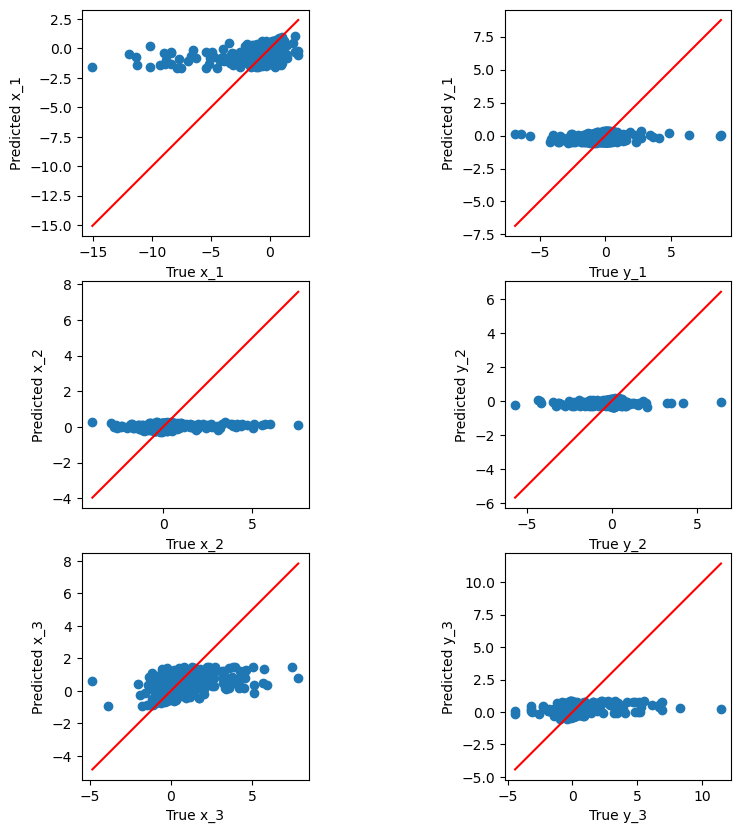

Removed   x0_1  RMSE = 1.4159063657148816


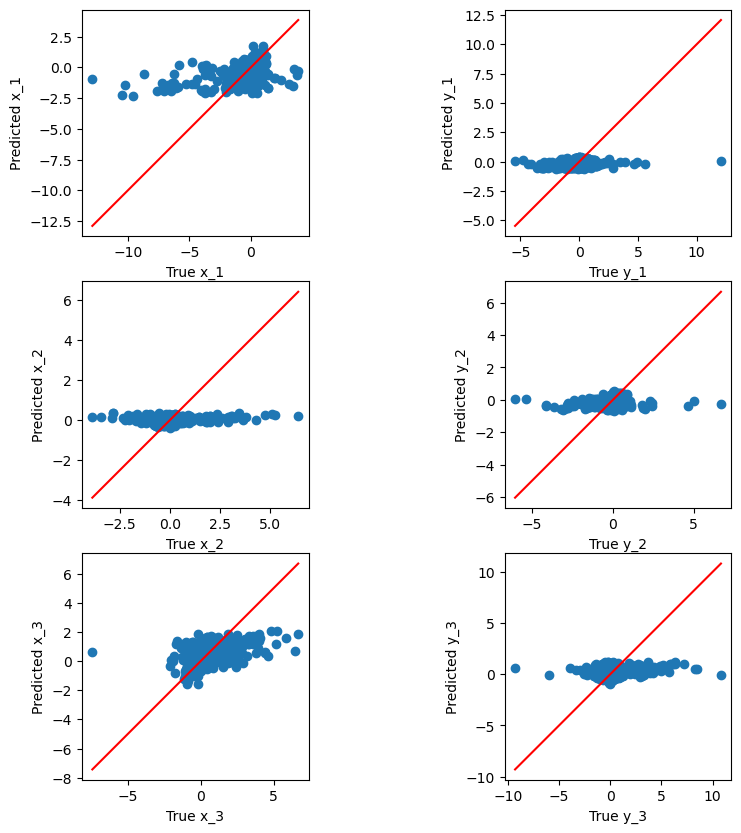

Removed   y0_1  RMSE = 1.4159063657148816


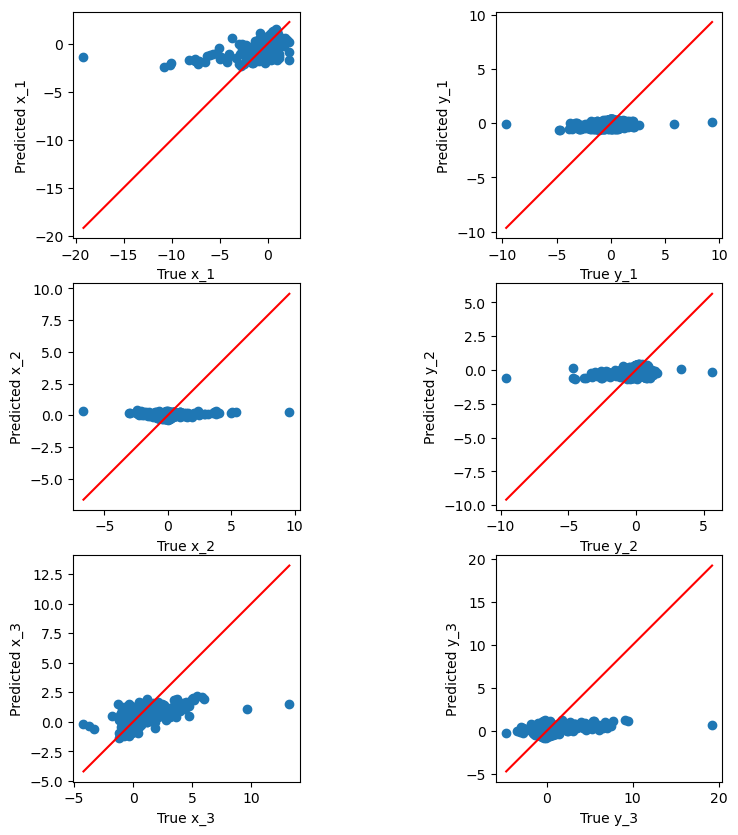

Removed   x0_2  RMSE = 1.4159063657148816


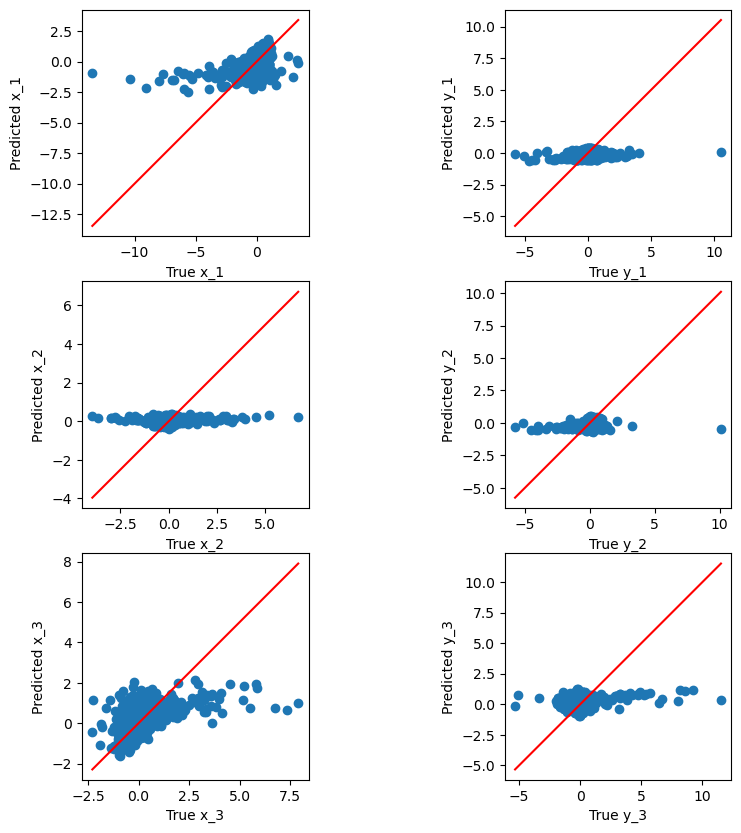

Removed   y0_2  RMSE = 1.4159063657148814


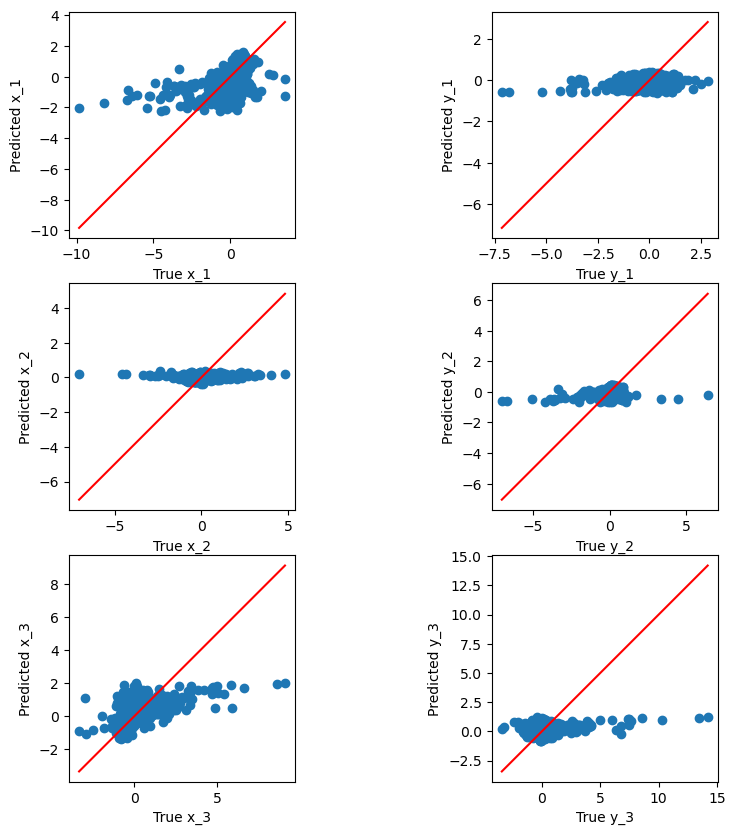

Removed   x0_3  RMSE = 1.4159063657148816


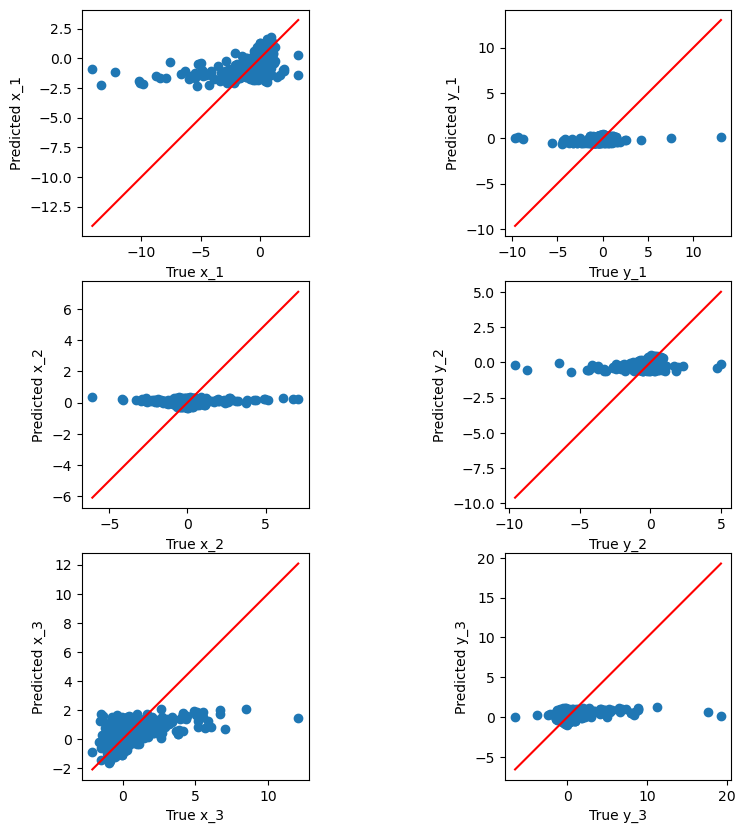

Removed   y0_3  RMSE = 1.4159063657148816


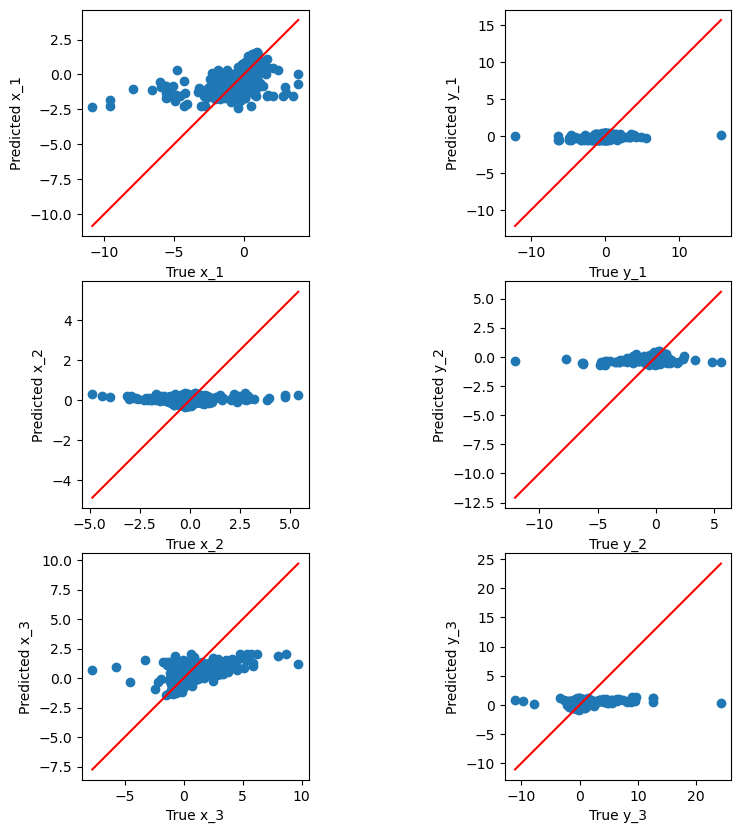

Impact of removing each feature:
  Removed Feature      RMSE
4            y0_2  1.415906
1            x0_1  1.415906
3            x0_2  1.415906
2            y0_1  1.415906
6            y0_3  1.415906
5            x0_3  1.415906
0               t  1.458784


In [12]:
#We want to correlate the variables "t" (features), and "x_1","y_1",x_2","y_2","x_3" and "y_3" (targets)
#Go get variable t from features
t_features=FEATURES.index("t")
t = X_va[:, t_features] #t is an array contains every value for each "t" (features)

#Join the values from "t" in X_val and x_1","y_1",x_2","y_2","x_3" and "y_3" in y_val
data=np.column_stack((t, y_va)) #Stack o t with y_val
cols=["t"]+TARGETS #Names of columns
df=pd.DataFrame(data, columns=cols) #forms the datatframe

#Pairplot
sns.pairplot(df.sample(200), kind="hist") #Sample of 200 to limit noise 
plt.suptitle("Pairplot with x_i, y_i") 
plt.show()

#Heatmap with correlation
corr=df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)
plt.title("Correlation between variables t, x_i e y_i", fontsize=14),
plt.tight_layout()
plt.show()

#Sort the interactions by the correlation values
corr_pairs=corr.unstack()  #Transform in series and pairs of variables
corr_pairs=corr_pairs.drop_duplicates()  #Removes duplicates (A,B) and (B,A)
sorted_corr=corr_pairs.reindex(corr_pairs.abs().sort_values(ascending=False).index)
print("Correlations by order:\n")
print(sorted_corr)

#Prininting RMSE without any removal 
baseline_rmse=rmse 
print(f" Baseline RMSE (WITHOUT REMOVAL): {baseline_rmse}")

#List do keep results 
results=[]

#Removing each feature
#For each feature in FEATURES
for feat in FEATURES:
    features_temporary = [f for f in FEATURES if f != feat]
    print(f"Removed {feat} → {len(features_temporary)} features left")

for feat in FEATURES:
    features_temporary=[f for f in FEATURES if f!= feat] #List of temporary features, is going to contain every feature minus the one that we want to measure the impact 
    
    #Creates new datasets 
    #tr_df contains every feature from training set ("t", "x_0_1", "y_0_1","x_0_2","y_0_2","x_0_3","y_0_3","x_1","y_1","x_2","y_2","x_3","y_3")
    #tr_df contains every feature from validation set ("t", "x_0_1", "y_0_1","x_0_2","y_0_2","x_0_3","y_0_3","x_1","y_1","x_2","y_2","x_3","y_3")
    X_tr_red = tr_df[features_temporary].values #Selects the "t", "x_0_1", "y_0_1","x_0_2","y_0_2","x_0_3","y_0_3"
    y_tr_red = tr_df[TARGETS].values #Selects "x_1","y_1","x_2","y_2","x_3","y_3"
    X_va_red = va_df[features_temporary].values 
    y_va_red = va_df[TARGETS].values
    
    #New model 
    model_red = make_pipeline(StandardScaler(with_mean=True), LinearRegression()) #Calls the regression pipeline
    model_red.fit(X_tr_red, y_tr_red)#Trains and validates with data with removed feature
    y_hat_red = model_red.predict(X_va_red)  #Previsions for each "x_1","y_1","x_2","y_2","x_3","y_3"
    
    #Calculate RMSE
    rmse_red = np.sqrt(mean_squared_error(y_va_red, y_hat_red))
    
    #Adds to the list the removed feature and the RMSE value for the prevision without the removed feature
    results.append({
        "Removed Feature": feat,
        "RMSE": rmse_red})
    print(f"Removed {feat:>6}  RMSE = {rmse_red}")
    
    #Plot y–ŷ for each removal
    plot_y_yhat(y_va_red, y_hat_red, plot_title=f"remove_{feat}_validation")

#Converts to DataFrame
results_df = pd.DataFrame(results).sort_values("RMSE")
print("Impact of removing each feature:")
print(results_df)

<h3>Task 3.2 - Evaluation of Variable Reduction</h3>

degree= 1 | feats=    1 | time=  0.01s | RMSE= 1.4754
degree= 2 | feats=    2 | time=  0.01s | RMSE= 1.4739
degree= 3 | feats=    3 | time=  0.01s | RMSE= 1.4734
degree= 4 | feats=    4 | time=  0.01s | RMSE= 1.4736
degree= 5 | feats=    5 | time=  0.01s | RMSE= 1.4729
Best RMSE with reduced Features: 1.4728799746132402


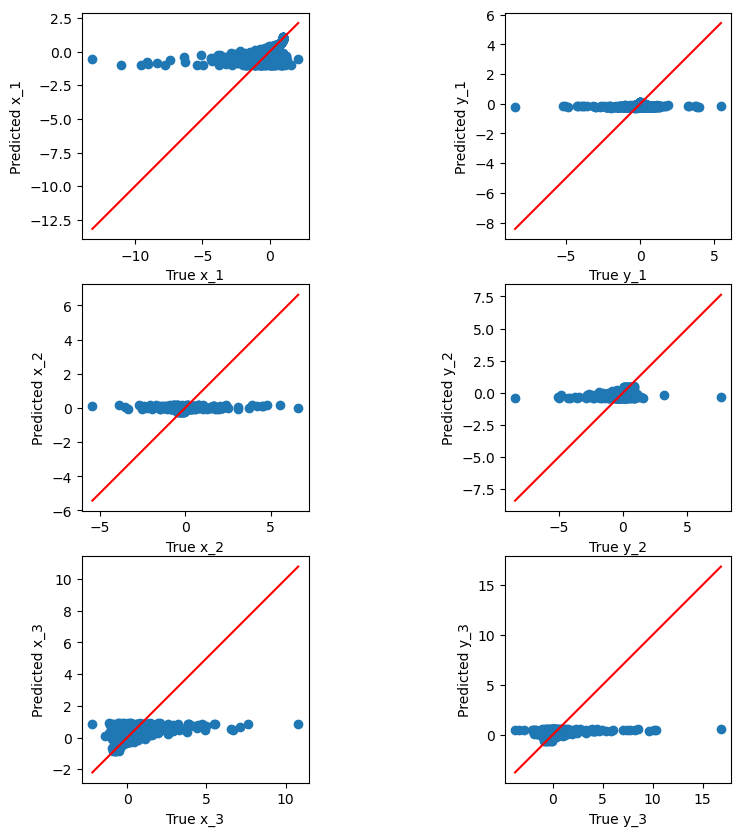

RMSE Task 2: 1.26375059574697
RMSE model with reduced features: 1.4728799746132402
reduced_polynomial_submission.csv created for submission to Kaggle.


In [13]:
#Creating only datatsets with variable "t" in features (X_tr and X_va)
X_tr_reduced = tr_df[["t"]].values 
X_va_reduced = va_df[["t"]].values
y_tr_reduced = tr_df[TARGETS].values
y_va_reduced = va_df[TARGETS].values

best_model_red, best_rmse_red, logs_red = validate_polynomial(
    X_tr_reduced, y_tr_reduced,
    X_va_reduced, y_va_reduced,
    degrees=range(1, 6),  
    max_features=1500,
    random_state=42,
    use_ridge=False,
    sample_frac=0.05,
    verbose=True
)

print(f"Best RMSE with reduced Features: {best_rmse_red}")

#Y-^y plot for comparing values
y_hat_red = best_model_red.predict(X_va_reduced) #Using prediction with reduced features on validation set

#Plot y–ŷ for the model with reduced features
plot_y_yhat(y_va_reduced, y_hat_red, plot_title="Reduced_features_validation")

#Comparison with Task 2
print(f"RMSE Task 2: {rmse_poly}")
print(f"RMSE model with reduced features: {best_rmse_red}")

#Submission to Kaggle
X_test_reduced = test[["t"]].values
y_test_reduced = best_model_red.predict(X_test_reduced)

reduced = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": y_test_reduced[:,0], "y_1": y_test_reduced[:,1],
    "x_2": y_test_reduced[:,2], "y_2": y_test_reduced[:,3],
    "x_3": y_test_reduced[:,4], "y_3": y_test_reduced[:,5],
})
submission.to_csv("../outputs/csv/reduced_polynomial_submission.csv", index=False)
print("reduced_polynomial_submission.csv created for submission to Kaggle.")

<h3>Task 3.3 - Adding Variables</h3>

In [14]:
#Adding new features
def add_new_features (df):
    eps = 1e-8 #Small value to avoid division by zero
    
    #Inverse of position (1/a)
    df["1/x0_1"]=1/(df["x0_1"]+eps)
    df["1/y0_1"]=1/(df["y0_1"]+eps)
    df["1/x0_2"]=1/(df["x0_2"]+eps)
    df["1/y0_2"]=1/(df["y0_2"]+eps)
    df["1/x0_3"]=1/(df["x0_3"]+eps)
    df["1/y0_3"]=1/(df["y0_3"]+eps)
    
    #Norms (sqrt(a^2))
    df["norm_1"] =np.sqrt(df["x0_1"]**2 + df["y0_1"]**2)
    df["norm_2"] =np.sqrt(df["x0_2"]**2 + df["y0_2"]**2)
    df["norm_3"] =np.sqrt(df["x0_3"]**2 + df["y0_3"]**2)
    
    #Distance between pairs (sqrt(a^2+b^2))
    df["distance_1_2"]=np.sqrt((df["x0_1"]-df["x0_2"])**2 + ((df["y0_1"]-df["y0_2"])**2))
    df["distance_1_3"]=np.sqrt((df["x0_1"]-df["x0_3"])**2 + ((df["y0_1"]-df["y0_3"])**2))
    df["distance_2_3"]=np.sqrt((df["x0_2"]-df["x0_3"])**2 + ((df["y0_2"]-df["y0_3"])**2))

    #Geometric center
    df["distance_of_x"]=(df["x0_1"] + df["x0_2"] + df["x0_3"]) / 3
    df["distance_of_y"]=(df["y0_1"] + df["y0_2"] + df["y0_3"]) / 3

    return df

#Apply to train and validation sets
train_new_features=add_new_features(tr_df)
validate_new_features=add_new_features(va_df)

#Updating the features set
NEW_FEATURES= FEATURES + [
    "1/x0_1","1/y0_1","1/x0_2","1/y0_2","1/x0_3","1/y0_3",
    "norm_1","norm_2","norm_3",
    "distance_1_2","distance_1_3","distance_2_3",
    "distance_of_x","distance_of_y"]

#Creating the new datasets
X_tr_new_features=train_new_features[NEW_FEATURES].values
y_tr_new_features=train_new_features[TARGETS].values
X_va_new_features=validate_new_features[NEW_FEATURES].values
y_va_new_features=validate_new_features[TARGETS].values

#Training baseline model with new added features
baseline_new_features = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline_new_features.fit(X_tr_new_features, y_tr_new_features)
y_hat_new_features = baseline_new_features.predict(X_va_new_features)  #Prevision in validation datatset

#Print the results
rmse_new_features = np.sqrt(mean_squared_error(y_va_new_features, y_hat_new_features))
print(f"Baseline RMSE (validation split) with new features: {rmse_new_features}")
print(f"RMSE Baseline original: {rmse_baseline}")

Baseline RMSE (validation split) with new features: 1.3651912487572309
RMSE Baseline original: 1.4159063657148816


<h3>Task 3.4 - Evaluation of Variable Augmentation</h3>

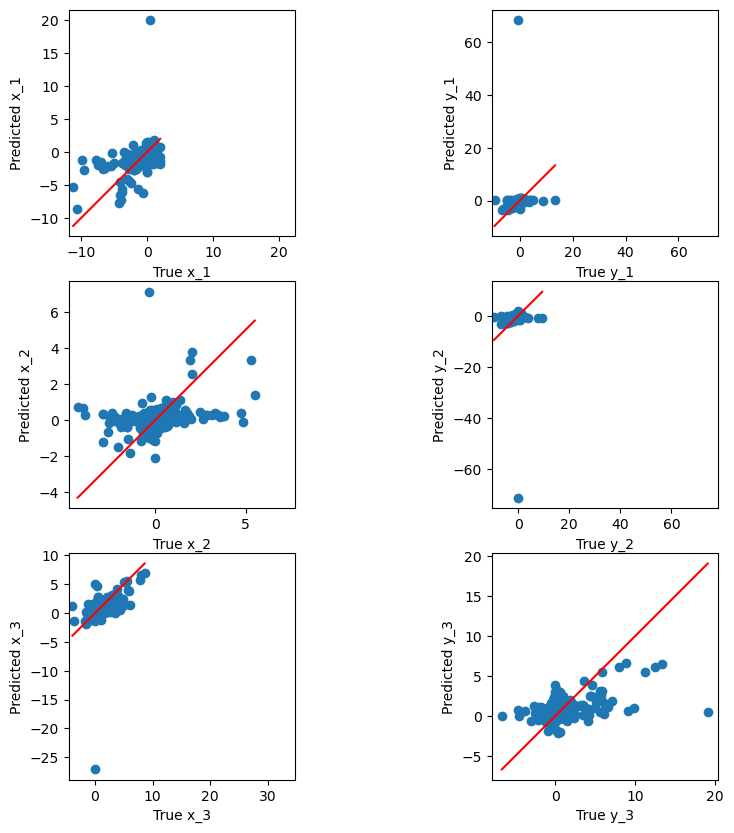

Polynomial RMSE (validation) with augmented features: 5.919037712970602
Polynomial RMSE (validation) without augmented features: 1.26375059574697


In [15]:
def add_new_features_augmentation (X):
    df=pd.DataFrame(X, columns=FEATURES)
    df_augmented=add_new_features(df)
    return df_augmented.values

#Using ColumnTransformer and FunctionTransformer to add new features 
#Augmenter applies the function add_new_features_augmentation to the columns in FEATURES
augmenter=FunctionTransformer(add_new_features_augmentation, validate=False)

#Applies the augmenter to the columns in FEATURES and leaves the rest of the columns unchanged
preprocessor=ColumnTransformer(
    transformers=[
        ('augment', augmenter, FEATURES)],
    remainder="passthrough")

#Pipeline with augmented features
#Transforms X_tr in X_aumented with the new features
polynomial_augmentation = make_pipeline(
    preprocessor,
    PolynomialFeatures(degree=3, include_bias=False), #Using only the best degree (should be 5)
    StandardScaler(),
    pick_regressor(use_ridge=True, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0))
)

X_tr = pd.DataFrame(X_tr, columns=FEATURES)
X_va = pd.DataFrame(X_va, columns=FEATURES)
X_test = pd.DataFrame(X_test, columns=FEATURES)
test_ids = test["Id"].astype(np.int64)

# Training the model with augmented features
polynomial_augmentation.fit(X_tr, y_tr)
y_hat_augmented=polynomial_augmentation.predict(X_va)  #Prevision

#Plot y–ŷ for the model with reduced features
plot_y_yhat(y_va, y_hat_augmented, plot_title="Augmented_features_validation")

#Print the results
rmse_augmented = np.sqrt(mean_squared_error(y_va, y_hat_augmented))
print(f"Polynomial RMSE (validation) with augmented features: {rmse_augmented}")
print(f"Polynomial RMSE (validation) without augmented features: {rmse_poly}")

#Exportation to Kaggle
X_test_augmentation = test[["t"]].values
y_test = polynomial_augmentation.predict(X_test)

#Saving submission in required format
augmentation = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": y_test[:,0], "y_1": y_test[:,1],
    "x_2": y_test[:,2], "y_2": y_test[:,3],
    "x_3": y_test[:,4], "y_3": y_test[:,5],
})

augmentation.to_csv("../outputs/csv/augmented_polynomial_submission.csv", index=False)

<h3>Task 4: Nonparametric Model — the k-Nearest Neighbors Regressor</h3>

<h3>Task 4.1 Development</h3>

In [16]:
#Compute RMSE again to evaluate the kNN model and compare different k values
#Keep the same metric to ensure consistency across all tested models (linear, polynomial, and non-parametric)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


#This function is used to test several k values in the k-Nearest Neighbors (kNN) model
#Measure the error (RMSE), training time, and inference time, and automatically choose the best k
#returns -> a dataframe with the results for all tested k values
#        -> the best k value (lowest RMSE)
#        -> the trained model corresponding to that best k
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15)):
    rows = []  #Stores the results for each k (one row per iteration): [k, train_time, pred_time, rmse]
    best = (None, np.inf, None)  # (k, rmse, model) — initialize a tuple representing the best model found so far

    for k in range(1,15):  #Loop to test k values between 1 and 14
        t0 = time.time()  #Measure start time of training
        model = make_pipeline(StandardScaler(),
                              KNeighborsRegressor(n_neighbors=k, weights="distance", p=2, n_jobs=-1))
        #Create a pipeline:
        #StandardScaler() normalizes the features (necessary because kNN is distance-based)
        #KNeighborsRegressor(...):
        #n_neighbors=k → number of neighbors to consider
        #weights='distance' → closer neighbors have higher weight
        #p=2 → use Euclidean distance
        #n_jobs=-1 → use all CPU cores for faster computation
        model.fit(X_train, y_train)  #train the model with the training set
        fit_t = time.time() - t0  #Measure training time duration

        t1 = time.time()  #Start another timer
        yhat = model.predict(X_val)  #Make predictions on the validation set
        #Here kNN computes distances between each validation sample and all training samples to find its k neighbors — the heaviest step
        pred_t = time.time() - t1  #Measure inference time

        err = rmse(y_val, yhat)  #Use the RMSE function defined above to compute mean error between true and predicted values
        rows.append([k, fit_t, pred_t, err])  #Add a row with all results for that k [k, train_time, pred_time, rmse]

        #Compare current error (err) with the best found so far (best[1]); if smaller, update the best tuple
        if err < best[1]:
            best = (k, err, model)

    #Create dataframe with results
    df = pd.DataFrame(rows, columns=["k", "train_time_s", "pred_time_s", "rmse"]).sort_values("rmse").reset_index(drop=True)
    return df, best[0], best[2]


#Build the catalog (dictionary) of available feature sets
#The dictionary will store, for each feature-set type, its corresponding training and validation data (X_tr, X_va)
FEATURE_SETS = {"baseline": (X_tr, X_va)}  #Baseline is mandatory

#Add reduced/augmented if they exist
#This block checks whether the variables X_tr_reduced and X_va_reduced exist in the environment
#If they do, it adds them to the FEATURE_SETS dictionary with the key "reduced"
#The same logic applies to the variables X_tr_aug and X_va_aug
if "X_tr_reduced" in globals() and "X_va_reduced" in globals():
    FEATURE_SETS["reduced"] = (X_tr_reduced, X_va_reduced)  #Variables created in Task 3.2

if "X_tr_aug" in globals() and "X_va_aug" in globals():
    FEATURE_SETS["augmented"] = (X_tr_aug, X_va_aug)  #Variables created in Task 3.4


#Run evaluation for each feature set
summary_rows = []  #Create an empty list to store results for each feature set
BEST_MODELS_4p1 = {}  #Store the best model of each set for use in Task 4.2

#This for loop iterates through each pair (name, (X_tr, X_va)) in the FEATURE_SETS dictionary
#"name" is the feature set name (e.g., "baseline", "reduced", "augmented")
#(X_train_set, X_val_set) are the training and validation matrices for that feature set
for name, (X_train_set, X_val_set) in FEATURE_SETS.items():
    print(f"\n=== Feature set: {name} ===")  #Print the name of the current feature set being evaluated
    df, best_k, best_model = validate_knn_regression(X_train_set, y_tr, X_val_set, y_va, k=range(1, 15))  #Call the validation function to evaluate kNN on this feature set
    print(df.head(10))  #Display the top 10 rows sorted by best RMSE
    best_row = df.iloc[0]  #Select the row with the lowest RMSE

    #Store summarized results
    summary_rows.append({
        "feature_set": name,
        "best_k": int(best_k),
        "best_rmse": float(best_row["rmse"]),
        "best_train_time_s": float(best_row["train_time_s"]),
        "best_pred_time_s": float(best_row["pred_time_s"]),
        "weights": "distance",
        "p": 2
    })
    #Store the best model to use later in Task 4.2
    BEST_MODELS_4p1[name] = {"k": int(best_k), "model": best_model}

    summary_df = pd.DataFrame(summary_rows).sort_values("best_rmse").reset_index(False)
    print("\n Resumo KNN por feature set (menor RMSE)")
    print(summary_df)


=== Feature set: baseline ===
    k  train_time_s  pred_time_s      rmse
0  14      0.685272     0.384339  1.032957
1  13      0.674311     0.414499  1.045802
2  12      0.685505     0.471758  1.050297
3  11      0.700269     0.390364  1.060416
4  10      0.689781     0.337195  1.073039
5   9      0.682899     0.316403  1.084845
6   8      0.693531     0.300520  1.087872
7   7      0.715200     0.320653  1.093302
8   6      0.697387     0.267094  1.100462
9   5      0.695198     0.329036  1.121163

 Resumo KNN por feature set (menor RMSE)
   index feature_set  best_k  best_rmse  best_train_time_s  best_pred_time_s  \
0      0    baseline      14   1.032957           0.685272          0.384339   

    weights  p  
0  distance  2  

=== Feature set: reduced ===
    k  train_time_s  pred_time_s      rmse
0  14      0.168753     3.829604  1.512616
1  13      0.171695     2.849205  1.522331
2  12      0.171120     2.811469  1.533481
3  11      0.175101     2.737612  1.546685
4   7      0.1

<h3>Task 4.2 Evaluation</h3>

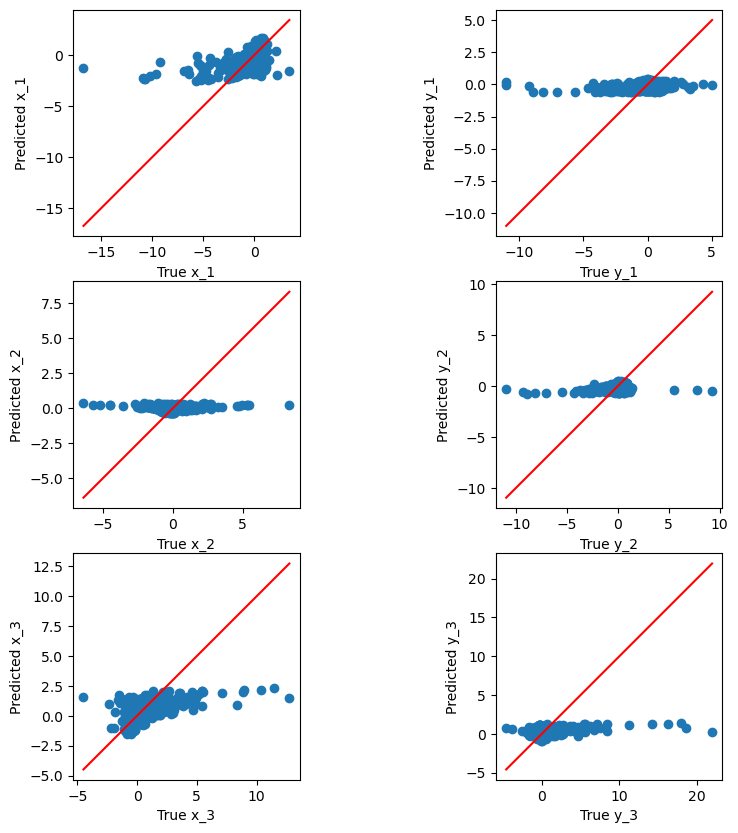

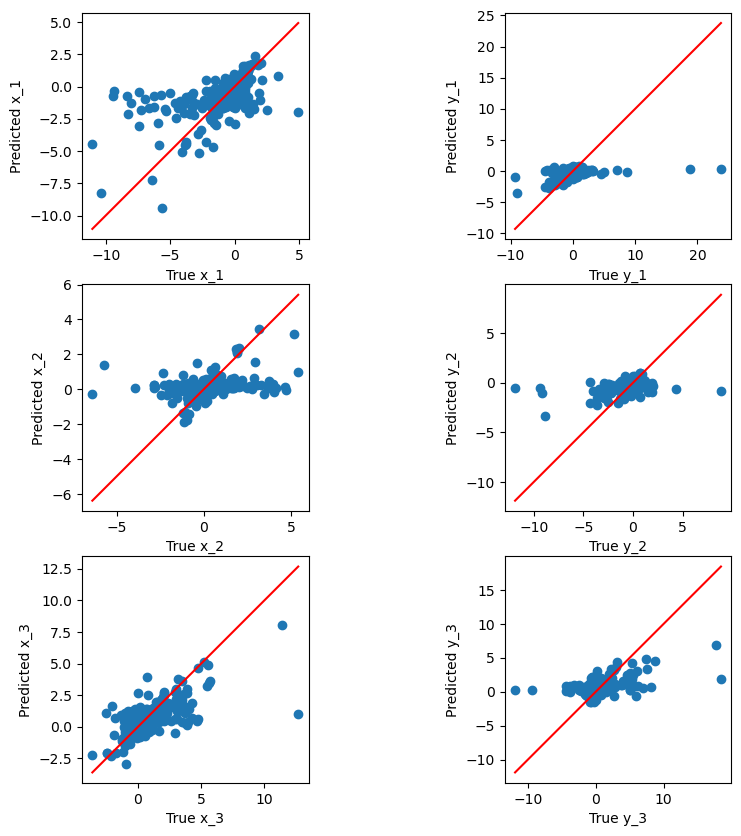

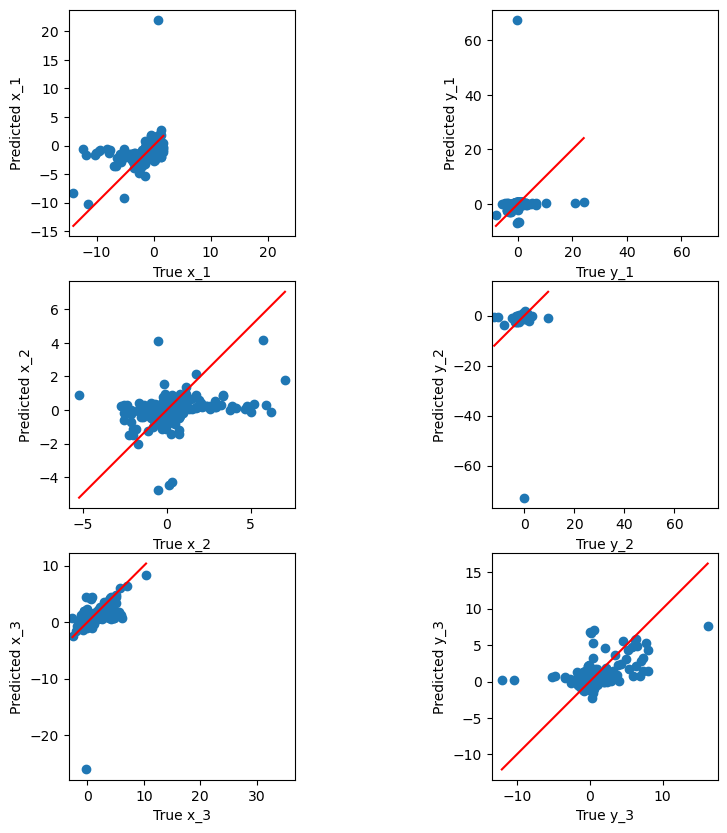

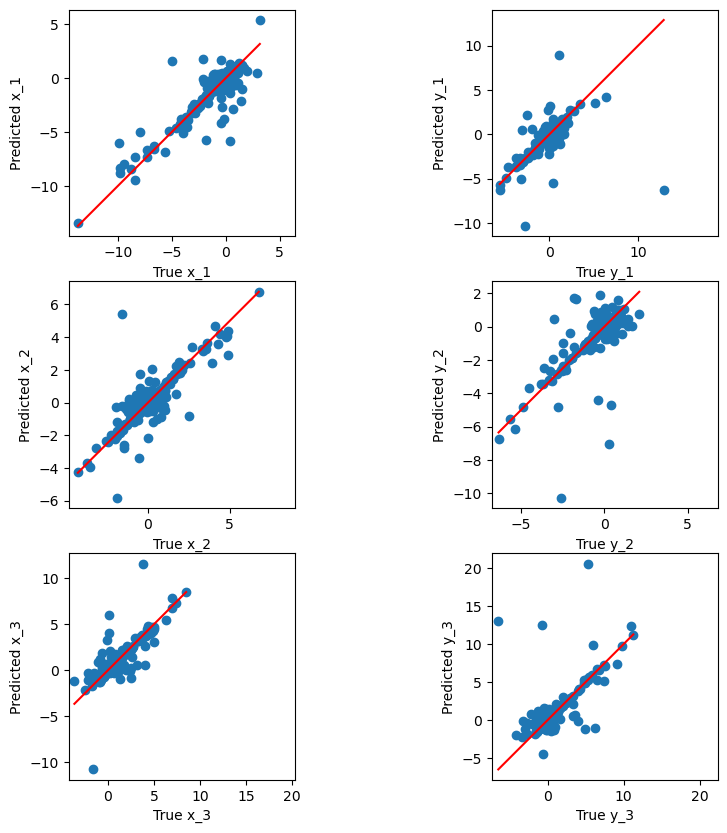

== RMSE comparison (validation) ==
                         Model  RMSE_total  RMSE_x_1  RMSE_y_1  RMSE_x_2  \
0           kNN (Task 4, k=14)    1.032955  1.094570  1.198588  0.758154   
1          Polynomial (Task 2)    1.260293  1.460082  1.328652  1.044247   
2  Baseline (LinearRegression)    1.415912  1.666677  1.417991  1.114458   
3        Feature Eng. (Task 3)    5.919038  1.659728  3.443187  9.284628   

   RMSE_y_2  RMSE_x_3  RMSE_y_3  
0  0.788293  0.952191  1.290117  
1  0.968489  1.040711  1.587884  
2  1.057683  1.264511  1.811251  
3  3.437449  9.257252  3.447135  
Saved: knn_submission.csv (batched prediction)


In [17]:
#SPEED PATCH for Task 4.2 
#Defines a tuple with the names of the six target variables
LABELS = ('x_1','y_1','x_2','y_2','x_3','y_3')

#Same metric used throughout the entire project
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

#Computes RMSE for each individual target variable and returns a pandas Series with the results
def rmse_per_target(y_true, y_pred, labels=LABELS):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)  # ensures y_true and y_pred are numpy arrays
    return pd.Series([rmse(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])], index=labels)  # creates a pandas Series with the results

#Function to predict in blocks (batches) to avoid RAM peaks and crashes
#(model = trained model, X = dataset to make predictions on, batch_size)
def predict_in_batches(model, X, batch_size=200_000):
    """Predicts X in batches to avoid RAM peaks and system freezes."""
    X = np.asarray(X, dtype=np.float32)  # Ensures X is a numpy array of type float32
    n, out_dim = X.shape[0], 6  # n = number of samples, out_dim = number of target variables (6)
    out = np.empty((n, out_dim), dtype=np.float32)  # Creates an empty array to store the predictions
    for i in range(0, n, batch_size):  #Loop through the dataset in blocks of size batch_size
        j = min(i + batch_size, n)  #Calculates the end index of the current block
        out[i:j] = model.predict(X[i:j]).astype(np.float32, copy=False)  #Makes predictions for the current block and stores them in 'out'
    return out
# 1) Baseline (fast)
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline.fit(X_tr.astype(np.float32), y_tr.astype(np.float32))  #Trains the model on the training data
y_hat_base = baseline.predict(X_va.astype(np.float32))  #Makes predictions on the validation set

# (optional) y–ŷ plots for the available models
# Baseline
plot_y_yhat(y_va, y_hat_base, plot_title="Baseline_validation")
# 2) Polynomial (Task 2) — uses the pipeline already chosen in Task 2 *if available*

y_hat_poly = None 
if 'chosen_model' in globals(): 
    #Only refit on the validation subset (fast); chosen_model already has the correct configuration
    chosen_model.fit(X_tr.astype(np.float32), y_tr.astype(np.float32))  #Refit on the training set
    y_hat_poly = chosen_model.predict(X_va.astype(np.float32))  #Prediction on the validation set

    # Polynomial (Task 2), if available
if y_hat_poly is not None:
    plot_y_yhat(y_va, y_hat_poly, plot_title="Polynomial_validation")

# 3) Feature Engineering (Task 3) — *avoid* heavy refit if not necessary
y_hat_feat = None
if 'polynomial_augmentation' in globals():
    # Warning: this can be heavy; if it takes too long, comment out these 3 lines
    polynomial_augmentation.fit(pd.DataFrame(X_tr, columns=FEATURES), y_tr)
    y_hat_feat = polynomial_augmentation.predict(pd.DataFrame(X_va, columns=FEATURES))

# Augmented features (Task 3), if available
if y_hat_feat is not None:
    # keep the original name used in Task 3 for consistency in your slides
    y_hat_augmented = y_hat_feat
    plot_y_yhat(y_va, y_hat_augmented, plot_title="Augmented_features_validation")

# 4) kNN (Task 4) — uses the best k from Task 4.1
best_k = int(summary_df.loc[summary_df['best_rmse'].idxmin(), 'best_k'])  # Best k found in Task 4.1
knn = make_pipeline(
    StandardScaler(with_mean=True),
    KNeighborsRegressor(n_neighbors=best_k, weights="distance", p=2, n_jobs=-1)
)
knn.fit(X_tr.astype(np.float32), y_tr.astype(np.float32))  #Trains the model on the training data
y_hat_knn = knn.predict(X_va.astype(np.float32))  #makes predictions on the validation set

# kNN (Task 4)
plot_y_yhat(y_va, y_hat_knn, plot_title=f"kNN_k{best_k}_validation")

# 5) RMSE Comparison (validation)
models = {"Baseline (LinearRegression)": y_hat_base, f"kNN (Task 4, k={best_k})": y_hat_knn}  #Dictionary to store model results
if y_hat_poly is not None: models["Polynomial (Task 2)"] = y_hat_poly  #Adds polynomial model result if available
if y_hat_feat is not None: models["Feature Eng. (Task 3)"] = y_hat_feat  #Adds feature engineering model result if available

rows = []
for name, yhat in models.items():  #Loop through each pair (model name, predictions)
    row = {"Model": name, "RMSE_total": rmse(y_va, yhat)}  #Computes total RMSE and stores it in the row
    row.update({f"RMSE_{lbl}": v for lbl, v in rmse_per_target(y_va, yhat).items()})  #Computes RMSE per target variable and adds it to the row
    rows.append(row)  #Appends the row to the list of results
eval_df = pd.DataFrame(rows).sort_values("RMSE_total").reset_index(drop=True)  #Creates a dataframe sorted by total RMSE
print("== RMSE comparison (validation) ==")
print(eval_df)

# 6) Kaggle Submission with the winning kNN — BATCHED PREDICTION
X_trva = np.vstack([X_tr, X_va]).astype(np.float32)  #Combines training and validation data to train the final model
y_trva = np.vstack([y_tr, y_va]).astype(np.float32)  #Combines training and validation targets

#Train the final model using the best k
final_knn = make_pipeline(
    StandardScaler(with_mean=True),
    KNeighborsRegressor(n_neighbors=best_k, weights="distance", p=2, n_jobs=-1)
)
final_knn.fit(X_trva, y_trva)  #Trains the model using train + validation data

#Ensure float32 and predict in batches (e.g., 200k)
X_test_np = np.asarray(X_test, dtype=np.float32)
y_test_pred = predict_in_batches(final_knn, X_test_np, batch_size=200_000)

#Save submission
knn_submission = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": y_test_pred[:,0], "y_1": y_test_pred[:,1],
    "x_2": y_test_pred[:,2], "y_2": y_test_pred[:,3],
    "x_3": y_test_pred[:,4], "y_3": y_test_pred[:,5],
})
knn_submission.to_csv("../outputs/csv/knn_submission.csv", index=False)
print("Saved: knn_submission.csv (batched prediction)")


<h2>Task 5</h2>

<h3> Task 5.2 - Stacking and Esemble <h3>

In [18]:
#Task 5
# ========= IMPORTS =========

import numpy as np
import pandas as pd

# Models and preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor

# Metrics
from sklearn.metrics import mean_squared_error
# Combine multiple models (polynomial, kNN, Random Forest, MLP) using manual stacking

# compute RMSE metric (same as before)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# --------- 1) Base Models ----------
# the 4 models will be combined later in the ensemble

# polynomial regression model (Task 2)
reg_final = RidgeCV(alphas=(0.01, 0.1, 1, 10, 100))  # L2 regularization
final_degree = 5  # degree chosen in Task 2

poly_model = make_pipeline(
    PolynomialFeatures(degree=int(final_degree), include_bias=False),  # generate terms up to degree 5
    StandardScaler(),  # normalize features
    reg_final  # ridge regression
)

# train polynomial model
poly_model.fit(X_tr, y_tr)
# make predictions on validation set
y_hat_poly = poly_model.predict(X_va)
# evaluate performance
rmse_poly = rmse(y_va, y_hat_poly)
print(f"Polynomial RMSE: {rmse_poly:.4f}")

# if 'best_k' does not exist, use a reasonable value (e.g., 12)

# kNN model (Task 4)
# try to use the best k found in Task 4; if not available, set k=12
try:
    _ = best_k
except NameError:
    best_k = 12

knn_model = make_pipeline(
    StandardScaler(), 
    KNeighborsRegressor(n_neighbors=best_k,  # number of neighbors
                        weights="distance",  # closer neighbors have higher weight
                        p=2,  # Euclidean distance
                        n_jobs=-1)  # use all CPU cores
)

# train and predict
knn_model.fit(X_tr, y_tr)
y_hat_knn = knn_model.predict(X_va)
rmse_knn = rmse(y_va, y_hat_knn)
print(f"kNN RMSE: {rmse_knn:.4f}")


# Random Forest model
rf_model = make_pipeline(
    StandardScaler(),  # (not needed for trees but kept for consistency)
    RandomForestRegressor(n_estimators=200,  # number of trees
                           max_depth=20,  # maximum depth
                           n_jobs=-1,  # use all CPU cores
                           random_state=42  # for reproducibility
                           )
)
rf_model.fit(X_tr, y_tr)
y_hat_rf = rf_model.predict(X_va)
rmse_rf = rmse(y_va, y_hat_rf)
print(f"Random Forest RMSE: {rmse_rf:.4f}")


# MLP model (Multi-Layer Perceptron)
mlp_model = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(64,32),  # two hidden layers with 64 and 32 neurons
                 activation='relu',  # ReLU activation function
                 learning_rate_init=0.001,  # learning rate
                 max_iter=200,  # maximum iterations
                 random_state=42)  # for reproducibility
)
mlp_model.fit(X_tr, y_tr)
y_hat_mlp = mlp_model.predict(X_va)
rmse_mlp = rmse(y_va, y_hat_mlp)
print(f"MLP RMSE: {rmse_mlp:.4f}")

# Comparison table
# 1.5 quick comparison between the four models
results = pd.DataFrame({
    'Model': ['Polynomial', 'kNN', 'Random Forest', 'MLP'],
    'RMSE': [rmse_poly, rmse_knn, rmse_rf, rmse_mlp]
}).sort_values('RMSE')
print(results)

# --------- 2) Manual STACKING (multi-output) ----------
# 2.1 Concatenate base model predictions as meta-model features (each predicts 6 columns)
# shape: [n_val, 6 * n_models] = [n_val, 24]
Z_va = np.hstack([y_hat_poly, y_hat_knn, y_hat_rf, y_hat_mlp]).astype(np.float32)

# Meta-model: RidgeCV multi-output
meta = MultiOutputRegressor(
    RidgeCV(alphas=(0.01, 0.1, 1, 10, 100)))  # linear regression with L2 regularization

# train meta-model on base model predictions
meta.fit(Z_va, y_va)

# final prediction on validation set
y_hat_stack = meta.predict(Z_va)
rmse_stack = rmse(y_va, y_hat_stack)
print(f"Stacked (manual) RMSE: {rmse_stack:.4f}")


# 2b) Weighted ensemble (simple alternative)
# instead of a meta-model, make a weighted average of predictions
# (optional) fixed-weight ensemble
preds_val = np.stack([y_hat_poly, y_hat_knn, y_hat_rf, y_hat_mlp], axis=-1)  # shape [n, 6, 4]

# define weights (sum = 1.0)
weights = np.array([0.3, 0.3, 0.2, 0.2], dtype=np.float32)
weights = weights / weights.sum()

# compute weighted mean: multiply each model by its weight
y_hat_ensemble = np.tensordot(preds_val, weights, axes=(2,0))               # [n, 6]

# evaluate simple ensemble
rmse_ensemble = rmse(y_va, y_hat_ensemble)
print(f"Weighted Ensemble RMSE: {rmse_ensemble:.4f}")

# --------- 3) Training on train+val and submission ----------
# now that the ensemble is chosen, train models on all data (train + val)
# to maximize performance on the test set

# 3.1 combine train and validation
X_trva = np.vstack([X_tr, X_va])
y_trva = np.vstack([y_tr, y_va])

# 3.2 retrain base models with more data
poly_model.fit(X_trva, y_trva)
knn_model.fit(X_trva, y_trva)
rf_model.fit(X_trva, y_trva)
mlp_model.fit(X_trva, y_trva)

# 3.3 make predictions on the test set
# build meta features for TEST
y_test_poly = poly_model.predict(X_test)
# kNN can be slow; if needed, batch predict, but run directly for simplicity
y_test_knn = knn_model.predict(X_test)
y_test_rf  = rf_model.predict(X_test)
y_test_mlp = mlp_model.predict(X_test)

# 3.4 stack predictions as meta-model features (z_test)
Z_test = np.hstack([y_test_poly, y_test_knn, y_test_rf, y_test_mlp]).astype(np.float32)

# 3.5 meta-model generates final predictions
y_test_pred = meta.predict(Z_test).astype(np.float32)

# 3.6 create submission CSV file
final = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": y_test_pred[:,0], "y_1": y_test_pred[:,1],
    "x_2": y_test_pred[:,2], "y_2": y_test_pred[:,3],
    "x_3": y_test_pred[:,4], "y_3": y_test_pred[:,5],
})
final.to_csv("../outputs/csv/final_ensemble_submission.csv", index=False)
print("Saved: ../outputs/csv/final_ensemble_submission.csv")


Polynomial RMSE: 1.2603
kNN RMSE: 1.0330
Random Forest RMSE: 1.2674
MLP RMSE: 0.8793
           Model      RMSE
3            MLP  0.879273
1            kNN  1.032957
0     Polynomial  1.260277
2  Random Forest  1.267438
Stacked (manual) RMSE: 0.7828
Weighted Ensemble RMSE: 0.9023


c:\Users\DESKTOP\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\DESKTOP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
c:\Users\DESKTOP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\DESKTOP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\DESKTOP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Saved: ../outputs/csv/final_ensemble_submission.csv
